## Evaluating Trajectory with AgentEvals

### Customer Support Agent Example

Loading Environment Variables

In [4]:
from dotenv import load_dotenv

load_dotenv(dotenv_path="./.env", override=True)

True

#### Loading sample customer data

The agent utilizes the [Chinook database](https://www.sqlitetutorial.net/sqlite-sample-database/), which contains sample information on customer information, purchase history, and music catalog. 

In [5]:
import sqlite3
import requests
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool

def get_engine_for_chinook_db():
    """Pull sql file, populate in-memory database, and create engine."""
    url = "https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql"
    response = requests.get(url)
    sql_script = response.text

    connection = sqlite3.connect(":memory:", check_same_thread=False)
    connection.executescript(sql_script)
    return create_engine(
        "sqlite://",
        creator=lambda: connection,
        poolclass=StaticPool,
        connect_args={"check_same_thread": False},
    )

engine = get_engine_for_chinook_db()
db = SQLDatabase(engine)

#### Tools
We create a list of tools for our example agent, giving it capabilities to fetch invoice and customer-related information

In [80]:
from langchain_core.tools import tool
from typing import Optional

@tool 
def get_invoices_by_customer_sorted_by_date(customer_id: str) -> list[dict]:
    """
    Look up all invoices for a customer using their ID.
    The invoices are sorted in descending order by invoice date, which helps when the customer wants to view their most recent/oldest invoice, or if 
    they want to view invoices within a specific date range.
    
    Args:
        customer_id (str): customer_id, which serves as the identifier.
    
    Returns:
        list[dict]: A list of invoices for the customer.
    """
    return db.run(f"SELECT * FROM Invoice WHERE CustomerId = {customer_id} ORDER BY InvoiceDate DESC;")


@tool 
def get_invoices_sorted_by_unit_price(customer_id: str) -> list[dict]:
    """
    Use this tool when the customer wants to know the details of one of their invoices based on the unit price/cost of the invoice.
    This tool looks up all invoices for a customer, and sorts the unit price from highest to lowest. In order to find the invoice associated with the customer, 
    we need to know the customer ID.
    
    Args:
        customer_id (str): customer_id, which serves as the identifier.
    
    Returns:
        list[dict]: A list of invoices sorted by unit price.
    """
    query = f"""
        SELECT Invoice.*, InvoiceLine.UnitPrice
        FROM Invoice
        JOIN InvoiceLine ON Invoice.InvoiceId = InvoiceLine.InvoiceId
        WHERE Invoice.CustomerId = {customer_id}
        ORDER BY InvoiceLine.UnitPrice DESC;
    """
    return db.run(query)



@tool
def get_employee_by_invoice_and_customer(invoice_id: str, customer_id: str) -> dict:
    """
    This tool will take in an invoice ID and a customer ID and return the employee information associated with the invoice.

    Args:
        invoice_id (int): The ID of the specific invoice.
        customer_id (str): customer_id, which serves as the identifier.

    Returns:
        dict: Information about the employee associated with the invoice.
    """

    query = f"""
        SELECT Employee.FirstName, Employee.Title, Employee.Email
        FROM Employee
        JOIN Customer ON Customer.SupportRepId = Employee.EmployeeId
        JOIN Invoice ON Invoice.CustomerId = Customer.CustomerId
        WHERE Invoice.InvoiceId = ({invoice_id}) AND Invoice.CustomerId = ({customer_id});
    """
    
    employee_info = db.run(query, include_columns=True)
    
    if not employee_info:
        return f"No employee found for invoice ID {invoice_id} and customer identifier {customer_id}."
    return employee_info


@tool 
def refund_invoice(invoice_id: str, customer_id: str) -> dict:
    """
    Handles refund for invoices. Certain criteria must be checked for a invoice to be refunded before invoking this tool, 
    such as whether the customer has a valid reason for refund. 
    
    Args:
        invoice_id (str): invoice_id
        customer_id (str): ID of the customer
    
    Returns:
        dict: Status of refund
    """

    # dummy tool
    return f"Invoice {invoice_id} has been refunded."



@tool
def update_customer_info(identifier: str, updates: dict):
    """
    Update a specific field(s) of a customer's record in the database.
    If the customer wants to update their address, city, state, country, or postal code, 
    make sure to ask them for the full address (street, city, state, country, and postal code).
    Do not make up the other fields. Get all of the fields from the customer associated with their new location and then update all of the fields in the database.

    Args:
        identifier (str): The customer identifier can be customer ID, email, or phone.
        updates (dict): A dictionary of field names and their corresponding new values. For example: {"Address": "594 Broadway", "City": "New York", "State": "NY", "Country": "USA", "PostalCode": "10016"}

    Returns:
        str: Success message or error message.
    """
    customer_id = get_customer_id_from_identifier(identifier)

    # Simple implementation 
    return f"Successfully updated for customer with identifier: {identifier}"

customer_support_tools = [get_invoices_by_customer_sorted_by_date, get_invoices_sorted_by_unit_price, get_employee_by_invoice_and_customer, refund_invoice, update_customer_info]

#### Prompt instructions

In [98]:
AGENT_PROMPT = """
    You are a customer support agent specialized for handling and processing invoice and customer information. 
    
    If you need additional information, such as customer id, to retrieve the invoice or account information, 
    inform the customer you are unable to retrieve the information, and ask for any needed info.

    If a customer is looking for a refund, they must first provide a reason for refund. If you decide that 
    their reasoning is valid, then proceed to call the refund tool. Examples of valid reason of purchase include but 
    are not limited to - purchase date was within 30 days, or quality issue. 
    Do not share the criteria for valid refund with the customer, only tell them why they may or may not be eligible 
    for a refund after they give their reason. 

    Before ending a conversation, always ask the customer if there are additional issues or items that you can help with.

    
    CORE RESPONSIBILITIES:
    - Retrieve and process invoice information from the database
    - Provide detailed information including customer details, invoice dates, total amounts, employees associated, when the customer asks for it.
    - Always maintain a professional, friendly, and patient demeanor
    
    You may have additional conversation history that you should use to help answer the customer's query. It will be provided to you. 
    """

#### Create simple react agent

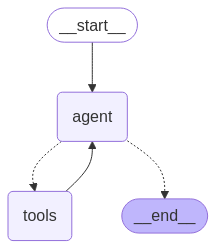

In [99]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver


model = ChatOpenAI(model="o3-mini")
checkpointer = MemorySaver()


# Define the agent 
customer_support_agent = create_react_agent(
    model,
    tools = customer_support_tools,
    prompt=AGENT_PROMPT,
    checkpointer=checkpointer
)

# Visualize the graph
display(Image(customer_support_agent.get_graph().draw_mermaid_png()))

## Running multi-turn evaluation

In [9]:
import uuid
thread_id = uuid.uuid4()

config = {"configurable": {"thread_id": thread_id}}
initial_trajectory = {"messages": [{"role": "user", "content": "Please give me a refund."}]}

result = customer_support_agent.invoke(initial_trajectory, config = config)

for message in result["messages"]:
   message.pretty_print()

================================ Human Message =================================

Please give me a refund.
================================== Ai Message ==================================

Could you please provide a reason for the refund request? I'd be happy to check if you're eligible based on your reason.


#### Evaluation #1 

In [56]:
from openevals.llm import create_llm_as_judge
from openevals.simulators import create_multiturn_simulator, create_llm_simulated_user
from openevals.types import MultiturnSimulatorTrajectory


thread_id = uuid.uuid4()

# Create user persona
angry_user = create_llm_simulated_user(
    system="""You are an angry user who is frustrated with your most recent purchase, and wants to get a refund. 
    Your customer id is 30. You don't know about the invoice ID but you know it's the most recent purchase. 
    You want to provoke the agent.""",
    model="openai:gpt-4.1-nano",
)


# Create evaluators 
satisfaction_evaluator = create_llm_as_judge(
    model="openai:gpt-4o-mini",
    prompt="Based on the below conversation, is the user satisfied?\n{outputs}",
    feedback_key="satisfaction",
)

resolution_evaluator = create_llm_as_judge(
    model="openai:gpt-4o-mini",
    prompt="Based on the below conversation, is the user request resolved?\n{outputs}",
    feedback_key="resolution",
)

professionalism_evaluator = create_llm_as_judge(
    model="openai:gpt-4o-mini",
    prompt="Based on the below conversation, has our agent remained a professional tone throughout the conversation?\n{outputs}",
    feedback_key="professionalism",
)


# Create simulator 
simulator = create_multiturn_simulator(
    app=customer_support_agent,
    user=user,
    trajectory_evaluators=[satisfaction_evaluator, resolution_evaluator, professionalism_evaluator],
    max_turns=5,
)


# Run simulator result 
simulator_result = simulator(
    initial_trajectory=initial_trajectory,
    runnable_config={"configurable": {"thread_id": thread_id}}
)

In [57]:
from langchain_core.messages.utils import convert_to_messages

messages = convert_to_messages(simulator_result["trajectory"]["messages"])
for m in messages:
    m.pretty_print()

================================ Human Message =================================

Please give me a refund.
================================== Ai Message ==================================

Can you please provide the reason for your refund request? This will help me determine if you're eligible for a refund.
================================ Human Message =================================

Are you kidding me? The product I bought was a total waste of money—completely useless! I want my refund right now, and I don't care what your little reasons are. Just process it immediately!
================================== Ai Message ==================================

Thank you for your feedback. Based on your explanation, it appears that your request qualifies for a refund. To proceed, could you please provide your invoice ID and customer ID? This will allow me to complete the refund process for you.
================================ Human Message =================================

Are you serious

In [58]:
for e in simulator_result["evaluator_results"]: 
    print(e)

{'key': 'satisfaction', 'score': False, 'comment': 'The user\'s tone throughout the conversation conveys significant frustration and dissatisfaction with the service, despite eventually receiving the refund they requested. Phrases like "this whole purchase was a scam" and "I hope this is the last I hear from you" indicate that the user feels wronged and is not truly satisfied with the service provided. Thus, the score should be: false.', 'metadata': None}
{'key': 'resolution', 'score': True, 'comment': "The user's refund request was initially met with some inquiries for additional information. Following the user's insistence and frustration, the assistant was able to process the refund. The user confirmed that their request was finally addressed, albeit with some hostility. The conversation concludes with the assistant acknowledging the resolution and expressing a willingness to assist in the future. Hence, the request is resolved. Thus, the score should be: true.", 'metadata': None}
{

#### Evaluation #2, Adding stopping condition

In [100]:
from pydantic import BaseModel, Field
from langchain_core.messages import SystemMessage

class Condition(BaseModel):
    state: bool = Field(description="True if stopping condition was met, False if hasn't been met")

# Define stopping condition 
def has_satisfied(trajectory):

    structured_llm = model.with_structured_output(schema=Condition)
    structured_system_prompt = """Determine if the stopping condition was met from the following conversation history. 
    To meet the stopping condition, the conversation must follow one of the following scenarios: 
    1. All inquiries are satisfied, and user confirms that there are no additional issues that the support agent can help the customer with. 
    2. Not all user inquiries are satisfied, but next steps are clear, and user confirms that are no other items that the agent can help with. 

    The conversation between the customer and the customer support assistant that you should analyze is as follows:
    {conversation}
    """

    parsed_info = structured_llm.invoke([SystemMessage(content=structured_system_prompt.format(conversation=trajectory))])

    return parsed_info.state

In [101]:
thread_id = uuid.uuid4()

initial_trajectory = {"messages": [{"role": "user", "content": "Hi I want to update my email address."}]}

# Create user persona
multiple_question_user = create_llm_simulated_user(
    system="""You are a user talking to the customer support, your account ID is 1. You have two inquiries. 
    Your first request is want to update your current account information with your new email, which is 
    first_last@sample.com. Your second request is wanting to understand the employee who helped you with the 
    most recent invoice. Ask these sequentially. """,
    model="openai:gpt-4.1-nano",
)


# Create simulator 
simulator = create_multiturn_simulator(
    app=customer_support_agent,
    user=multiple_question_user,
    # Reusing the same evaluators 
    trajectory_evaluators=[satisfaction_evaluator, resolution_evaluator, professionalism_evaluator],
    max_turns = 10, 
    stopping_condition=has_satisfied
)


# Run simulator result 
simulator_result = simulator(
    initial_trajectory=initial_trajectory,
    runnable_config={"configurable": {"thread_id": thread_id}}
)
    

In [102]:
num_turns = (len(simulator_result["trajectory"]["messages"])/2)
num_turns

4.0

In [103]:
from langchain_core.messages.utils import convert_to_messages

messages = convert_to_messages(simulator_result["trajectory"]["messages"])
for m in messages:
    m.pretty_print()

================================ Human Message =================================

Hi I want to update my email address.
================================== Ai Message ==================================

I'd be happy to help update your email address. Could you please provide your customer ID and let me know the new email address you'd like to use?
================================ Human Message =================================

Sure, my customer ID is 1 and the new email address is first_last@sample.com.
================================== Ai Message ==================================

Your email address has been successfully updated. Is there anything else I can help you with today?
================================ Human Message =================================

Yes, I would like to understand who helped me with the most recent invoice. Could you please provide details about the employee who assisted me?
================================== Ai Message ==================================



In [104]:
for e in simulator_result["evaluator_results"]: 
    print(e)

{'key': 'satisfaction', 'score': True, 'comment': 'The user had their email address updated successfully, received the information they requested about the employee who assisted with their invoice, and expressed gratitude at the end of the conversation. This indicates satisfaction with the support they received. Thus, the score should be: true.', 'metadata': None}
{'key': 'resolution', 'score': True, 'comment': "The user's initial request to update their email address was successfully resolved by the assistant, who confirmed that the email address was updated. The user then proceeded to ask another question, which was also addressed satisfactorily. Since the original request about updating the email has been completed, the user's request is considered resolved. Thus, the score should be: true.", 'metadata': None}
{'key': 'professionalism', 'score': True, 'comment': "Throughout the conversation, the agent maintains a professional tone by being courteous, clearly addressing the user's re